In [1]:
import numpy as np
import math
from functools import reduce
import time
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)
from pathlib import Path
import nidaqmx

def lcm(a, b):
    """Calculate the least common multiple of two numbers."""
    return abs(a * b) // math.gcd(a, b)


def lcm_of_list(numbers):
    """Find the LCM of a list of numbers."""
    return reduce(lcm, numbers)

def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

# some constants
Hz = 1e-9 # GHz
kHz = 1e-6 # GHz
MHz = 1e-3 # GHz
pi = np.pi

In [2]:
# from logmodule import setup_logging


In [3]:
# setup_logging()
# logger = logging.getLogger(__name__)


In [4]:
import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
from nidaqmx.stream_readers import AnalogSingleChannelReader

from hardware import config as hcf
from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import (
    OutputState,
    TriggerStart,
    TriggerRearm,
    HIGH,
    LOW,
    INF,
    REPEAT_INFINITELY
)
timebase = lcm_of_list(
    [hcf.VDISYN_timebase, hcf.SIDIG_timebase, hcf.PS_timebase, hcf.RSRF_timebase]
)

hw = HardwareManager()
# adds synthesizer, laser, and pulse generator 
hw.add_default_hardware()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [5]:
# pulse streamer pulse sequence 

def sequence_mw_phase_calibration(
    init_nslaser: int,
    init_isc: int,
    init_wait: int,
    init_repeat: int,
    read_wait: int,
    read_laser: int,
    mw_dur: int,
):
    seq_exp = []

    sub_init = [(["laser"], init_nslaser), ([], init_isc)] * init_repeat + [
        ([], init_wait)
    ]

    sub_evo_MWA = [(["mwA"], mw_dur)]
    sub_evo_MAB = [(["mwB"], mw_dur)]


    sub_read = [([], read_wait), (["laser", "sdtrig"], read_laser)]

    seq_exp += sub_init + sub_evo_MWA + sub_evo_MAB+ sub_read

    sub_evo_noMW = [([], mw_dur)]

    seq_exp += sub_init + sub_evo_noMW+ sub_evo_noMW + sub_read # add two elements of sub_evo_noMW to account for the 2 x mwdur in MWA and MAB

    _aux = None

    return seq_exp, _aux

In [6]:
# DEFINE THE PARAMETERS
paraset = dict(
            mw_phasevolt_start=0,  # Volts
            mw_phasevolt_stop=0.6,  # Volts
            mw_phasevolt_step=0.005,  # Volts
            # -------------------
            # init_laser=1500.0,
            init_wait=250.0,
            init_nslaser=250,
            init_isc=250,
            init_repeat=50,
            mw_time=125.0,
            read_wait=500.0,
            read_laser=1201.0,
            # -------------------
            mw_phasevolt=5.0,
            laser_current=35,  # 0 to 100%
            amp_input=1000,  # input amplitude for digitizer
            repeat_daq=10,
            bz_bias_vol=1,  # -1V to 1V
            # -------------------
            rate_refresh=30.0,  # Hz rate of refreshing the entire spectrum, approx
            ODMR_freq=392.83,
        )


In [7]:
# DEFINE THE DATASET
dataset = dict(
    num_repeat=0,
    phasevolt=np.zeros(
        len(
            np.arange(
                paraset["mw_phasevolt_start"],
                paraset["mw_phasevolt_stop"],
                paraset["mw_phasevolt_step"],
            )
        )
    ),
    signal=np.zeros(
        len(
            np.arange(
                paraset["mw_phasevolt_start"],
                paraset["mw_phasevolt_stop"],
                paraset["mw_phasevolt_step"],
            )
        )
    ),
    background=np.zeros(
        len(
            np.arange(
                paraset["mw_phasevolt_start"],
                paraset["mw_phasevolt_stop"],
                paraset["mw_phasevolt_step"],
            )
        )
    )
)

In [8]:
# SETUP THE EXPERIMENT
# set the frequency array----------------------------------------------
mw_phasevolt_start = paraset["mw_phasevolt_start"]
mw_phasevolt_stop = paraset["mw_phasevolt_stop"]
mw_phasevolt_step = paraset["mw_phasevolt_step"]
ODMR_freq = paraset["ODMR_freq"]
mw_phasevolt_array = np.arange(mw_phasevolt_start, mw_phasevolt_stop, mw_phasevolt_step)
num_phase = len(mw_phasevolt_array)
# just to see if we can set the freq in the mwsyn
freq = ODMR_freq
hw.vdi.set_freq(freq) 
# set the MW power----------------------------------------------
mwpower_level = 5
hw.vdi.set_amp_volt(mwpower_level) 

# set the measurement sequence-------------------------------------------
seq_exp, _ = sequence_mw_phase_calibration(
    paraset["init_nslaser"],
    paraset["init_isc"],
    paraset["init_wait"],
    paraset["init_repeat"],
    paraset["read_wait"],
    paraset["read_laser"],
    paraset["mw_time"],
)
tt_seq = seqtime(seq_exp)

hw.pg.setSequence(seq_exp, reset=True)
hw.pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)

read_wait = paraset["read_wait"]
read_laser = paraset["read_laser"]
databufferlen = 2  # mw on and mw off

rate_refresh = paraset[
    "rate_refresh"
]  # Hz rate of refreshing the data streaming

amp_input = paraset["amp_input"]
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = (
    int(databufferlen / (tt_seq * rate_refresh / 1e9)) // 32 * 32
)  # number of "reads" every data refresh

# configures the readout to match the pulse sequence
pretrig_size = (
    int((read_wait / 2) * hcf.SIDIG_maxsr / 1e9) // 64 * 64
)  # pretrigger based on the t_wait time
posttrig_size = (
    int((read_laser) * hcf.SIDIG_maxsr / 1e9) // 64 * 64
)  # posttrigger based on the t_laser time and init_isc
segment_size = pretrig_size + posttrig_size
segment_size = 2 ** int(np.log2(segment_size) + 1)  # make it power of 2
posttrig_size = (
    segment_size - pretrig_size
)  # recalculate posttrigger size to ensure it is power of 2
bgextend_size = 256
# To set the configuration, make a dictionary with the key and value
hw.dig.reset_param()
hw.dig.assign_param(
    dict(
        readout_ch=readout_ch,
        amp_input=amp_input,
        num_segment=num_segment,
        pretrig_size=pretrig_size + bgextend_size,  # TODO: why 256?
        posttrig_size=posttrig_size - bgextend_size,
        segment_size=segment_size,
    )
)

hw.dig.set_ext_clock() # TODO does this need to be set during the loop 
# hw.dig.set_config() 
# -----------------------------------------------------------------------

# set the pulse streamer stream-------------------------------------------
hw.pg.setClock10MHzExt() # TODO does this need to be set during the loop 
# hw.pg.stream(n_runs=num_segment // databufferlen)

# set the laser power -------------------------------------------------
current_percent = paraset["laser_current"]
hw.laser.laser_off()
hw.laser.set_analog_control_mode("current")
hw.laser.set_modulation_state("Pulsed")
hw.laser.set_diode_current(current_percent, save_memory=False)
hw.laser.laser_on()  # turn on laser

# Allocate arrays and arguments for the experiment------------------------------------------------

num_seg_singelfreq = num_segment
# num_phase = num_phase
phase_actual = np.copy(mw_phasevolt_array)
segment_list = np.zeros_like(phase_actual)
sig_mwon_raw = np.zeros((len(phase_actual), segment_size))
sig_mwoff_raw = np.zeros((len(phase_actual), segment_size))
sig_mwon = np.zeros_like(phase_actual)
sig_mwoff = np.zeros_like(phase_actual)
num_repeat = 10
phase_idx = 0

# start the digitizer buffering------------------------------------
hw.dig.set_config()
# hw.dig.start_buffer()



In [9]:
hw.pg.plotSeq(plot_all=False)


In [10]:
# Run the experiment
for mmm in range(4):
    for jj, ff in enumerate(mw_phasevolt_array): # jj loop counter # ff actual element 
        # jj = phase_idx % num_phase
        # ff = phase_actual[phase_idx]
        current_mwphasevolt = ff
        print(current_mwphasevolt)
        hw.vdi.set_phase_volt(current_mwphasevolt)
        hw.pg.rearm()
        hw.dig.assign_param(
            dict(
                readout_ch=readout_ch,
                amp_input=amp_input,
                num_segment=num_segment,
                pretrig_size=pretrig_size + bgextend_size,  # TODO: why 256?
                posttrig_size=posttrig_size - bgextend_size,
                segment_size=segment_size,
            )
        )
        hw.dig.set_config()
        hw.pg.stream(n_runs=num_segment // databufferlen)
        hw.dig.start_buffer()
        hw.pg.startNow()

        time.sleep(1.0 / paraset["rate_refresh"])
        num_seg_collected = 0
        
        while num_seg_collected < num_segment:
            rawraw = hw.dig.stream()
            if rawraw is not None:
                
                num_seg_collected = rawraw.shape[0]
                print("num_seg_collected", num_seg_collected)
                rawraw_all = np.reshape(rawraw, (num_seg_collected, -1))
                rawraw_on = rawraw_all[0::2, :]
                rawraw_off = rawraw_all[1::2, :]
                sig_mwon_raw[jj, :] += np.sum(rawraw_on, axis=0)
                sig_mwoff_raw[jj, :] += np.sum(rawraw_off, axis=0)
                segment_list[jj] += num_seg_collected
        
        hw.dig.stop_card()
        # time.sleep(1)
        # print(phase_idx)



0.0
num_seg_collected 1216
Card stopped
0.005
num_seg_collected 1216
Card stopped
0.01
num_seg_collected 1216
Card stopped
0.015
num_seg_collected 1216
Card stopped
0.02
num_seg_collected 1216
Card stopped
0.025
num_seg_collected 1216
Card stopped
0.03
num_seg_collected 1216
Card stopped
0.035
num_seg_collected 1216
Card stopped
0.04
num_seg_collected 1216
Card stopped
0.045
num_seg_collected 1216
Card stopped
0.05
num_seg_collected 1216
Card stopped
0.055
num_seg_collected 1216
Card stopped
0.06
num_seg_collected 1216
Card stopped
0.065
num_seg_collected 1216
Card stopped
0.07
num_seg_collected 1216
Card stopped
0.075
num_seg_collected 1216
Card stopped
0.08
num_seg_collected 1216
Card stopped
0.085
num_seg_collected 1216
Card stopped
0.09
num_seg_collected 1216
Card stopped
0.095
num_seg_collected 1216
Card stopped
0.1
num_seg_collected 1216
Card stopped
0.105
num_seg_collected 1216
Card stopped
0.11
num_seg_collected 1216
Card stopped
0.115
num_seg_collected 1216
Card stopped
0.12
n

In [11]:
def average_repeated_data( arr, start, stop, segments):
    averaged_norm = np.mean(arr[:, start:stop], axis=1)
    averaged_bg = np.mean(
        arr[:, bgextend_size - 156 : bgextend_size - 56], axis=1
    )  # TODO: use parameters instead of fixed number to select background

    averagednormalized = averaged_norm - averaged_bg
    result = np.divide(
        averagednormalized,
        segments,
        out=np.zeros_like(averagednormalized, dtype=float),
        where=segments != 0,
    )
    return result


In [12]:
# ORGANIZE THE DATA
sig_mwon = average_repeated_data(
    sig_mwon_raw,
    bgextend_size + 160,
    bgextend_size + 400,
    segment_list,
)
sig_mwoff = average_repeated_data(
    sig_mwoff_raw,
    bgextend_size + 160,
    bgextend_size + 400,
    segment_list,
)

# dataset["signal"] = sig_mwon
# dataset["background"] = sig_mwoff
# # dataset["phase"] = phase
# dataset["num_repeat"] = np.mean(segment_list)




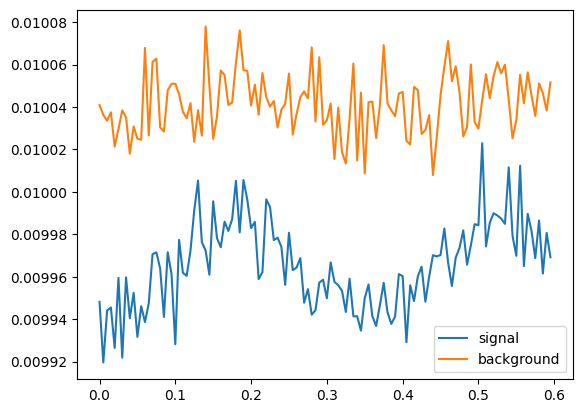

In [13]:
plt.plot(phase_actual, sig_mwon, label="signal")
plt.plot(phase_actual, sig_mwoff, label="background")
# plt.plot(phase_actual, sig_mwon - sig_mwoff, label="signal - background")
plt.legend()
plt.show()

In [14]:
plt.plot(phase_actual, sig_mwon - sig_mwoff, label="signal - background")


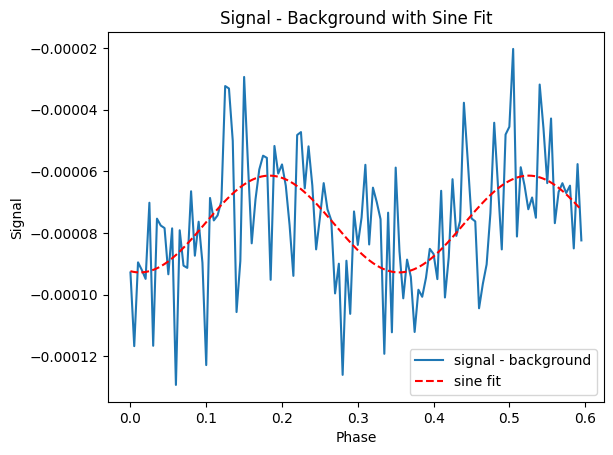

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Your original data
x = phase_actual
y = sig_mwon - sig_mwoff

# Define a sine model: A * sin(2π f x + φ) + C
def sine_model(x, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * x + phi) + C

# Initial guess: [Amplitude, Frequency, Phase, Offset]
guess = [np.max(y) - np.min(y), 1 / (x[-1] - x[0]), 0, np.mean(y)]

# Fit the data
popt, _ = curve_fit(sine_model, x, y, p0=guess)

# Generate smooth x values for plotting the fitted curve
x_fit = np.linspace(np.min(x), np.max(x), 1000)
y_fit = sine_model(x_fit, *popt)

# Plot
plt.plot(x, y, label="signal - background")
plt.plot(x_fit, y_fit, label="sine fit", linestyle="--", color="red")
plt.legend()
plt.xlabel("Phase")
plt.ylabel("Signal")
plt.title("Signal - Background with Sine Fit")
plt.show()


In [16]:
# SHUTDOWN THE EXPERIMENT
# # reconnect the mw syn connection
# hw.mwsyn.close_gracefully()
# hw.mwsyn.open()
hw.vdi.set_amp_volt(0)

# turn off laser and set diode current to zero
hw.laser.laser_off()  # turn off laser
hw.laser.set_diode_current(0.0, save_memory=False)

hw.dig.stop_card()
# hw.dig.reset()

# pasue the mw pause then reboot
# hw.mwsyn.sweep_pause()

# mwsyn.reboot()

# clear the pulse sequence
hw.pg.forceFinal()
hw.pg.rearm()
hw.pg.constant(OutputState.ZERO())
# hw.pg.reset()

Card stopped
